In [10]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

import glob
import gc
import warnings
import copy
import pathlib
import pickle

import os
import shutil

from scipy import stats
import signac
import freud
import gsd.hoomd
import hoomd
import schmeud
import schmeud._schmeud as schmeud_rs
from schmeud._schmeud import statics
from schmeud._schmeud import locality
from schmeud import ml
from tqdm import tqdm

from dataclasses import dataclass
from collections import defaultdict

from numba import njit

In [11]:
from monk import nb, prep as prep_mod, pair, render, utils, workflow, grid

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [12]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 18, 'dt': 0.005, 'step_unit': 200, 'equil_time': 100, 'min_periods': 20, 'dumps': 40, 'period_times': [30.0, 100.0, 300.0, 1000.0], 'max_shears': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12], '_status': {}}

In [14]:
@dataclass(frozen=True, eq=True)
class Statepoint:
    max_shear: float
    period: float
    temp: float
    prep: str

In [15]:
# let's look at the softess distributions when normalized

In [16]:
class InteractionComputer:

    def _setup_nve_sim(self, pot, dt=0.01):
        if isinstance(pot, str):
            pot = [pot]
        elif isinstance(pot, list):
            pass
        else:
            raise ValueError("The 'potential' must be a string or list")

        integrator = hoomd.md.Integrator(dt=dt)
        pair_func, args = prep_mod.search_for_pair(pot)
        tree = hoomd.md.nlist.Tree(0.3)
        print("Using pair function: ", pair_func)
        force = pair_func(tree, *args)

        nvt = hoomd.md.methods.NVE(hoomd.filter.All())
        integrator.forces = [force]
        integrator.methods = [nvt]

        self._sim.operations.integrator = integrator

        self._nlist = tree

        return nvt

    def __init__(self, filename, pot, frame=0, device=None, seed=None):
        if device is None:
            device = hoomd.device.CPU()
        sim = hoomd.Simulation(device, seed=seed)
        sim.create_state_from_gsd(filename, frame=frame)
        self._sim = sim
        self._file_handle = gsd.hoomd.open(name=filename, mode='rb')

        self._setup_nve_sim(pot)

        self._sim.always_compute_pressure = True

        self._snap = None

        sim.run(0)

    def get_forces(self):
        assert len(self._sim.operations.integrator.forces) == 1
        self._sim.run(0)
        return self._sim.operations.integrator.forces[0].forces
    
    def get_virials(self):
        assert len(self._sim.operations.integrator.forces) == 1
        self._sim.run(0)
        return self._sim.operations.integrator.forces[0].virials
    
    def get_pairs(self):
        self._sim.run(0)
        return self._nlist.pair_list()
    
    def get_snapshot(self):
        if self._snap is None or self._sim.timestep != self._snap.configuration.step:
            self._snap = self._sim.state.get_snapshot()
        return self._snap

    def get_positions(self):
        snap = self.get_snapshot()
        return snap.positions
    
    def get_box(self):
        return self._sim.state.box

    def set_frame(self, frame):
        snap = self._file_handle[frame]
        snap = hoomd.Snapshot.from_gsd_snapshot(snap, hoomd.communicator.Communicator())
        self._sim.state.set_snapshot(snap)

    def set_file(self, filename, frame=0):
        self._file_handle = gsd.hoomd.open(name=filename, mode='rb')
        self.set_frame(frame)

In [17]:
vmin = 0
vmax = 10
norm = colors.Normalize(vmin=vmin, vmax=vmax)
# norm = colors.LogNorm(vmin=vmin, vmax=vmax)
# mshear = 0.08

In [18]:
def clear_fig_and_plot_grid(ax, grid, norm, mshear, prep, colorbar=True):
    ax.clear()
    flip = grid.T
    # fig, ax = plt.subplots(figsize=(5, 4))
    cb = ax.matshow(flip, norm=norm, cmap="viridis")
    plt.title(f"prep={prep}   strain={mshear*100:.0f}%")
    if colorbar:
        plt.colorbar(cb, label="virial trace")

In [206]:
@njit
def mean_over_neighbors(input, segments, neighbor_counts, point_indices):
    output = np.zeros_like(input)
    for i, (seg, nneigh) in enumerate(zip(segments, neighbor_counts)):
        neighbors = point_indices[seg:seg+nneigh]
        output[i] = np.mean(input[neighbors])
    return output

634e14bc75836df75158fb15f379d8bb
HTL
Using pair function:  <function KA_LJ at 0x777eef7ebac0>


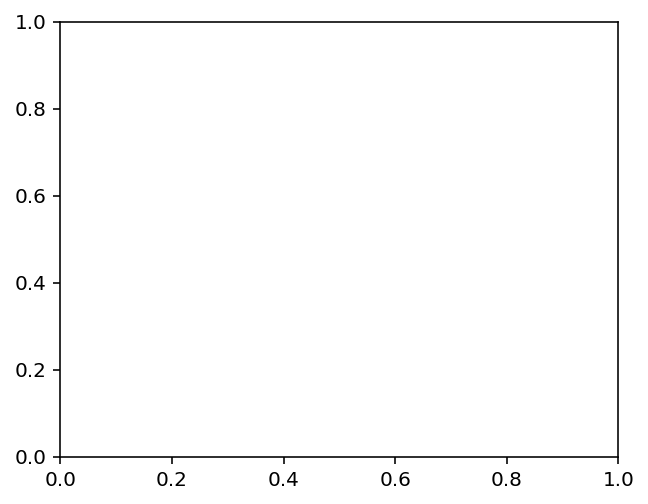

In [309]:
output = defaultdict(list)

fig, ax = plt.subplots(figsize=(5, 4))
colorbar = True

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "HTL":
        continue
    print(prep)
    txt_prep = prep.lower()
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    inter_computer = InteractionComputer(experiments[0], job.sp["pot"], frame=0)
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3 or float(max_shear) != 0.03:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue

        inter_computer.set_file(exper, frame=0)

        traj = gsd.hoomd.open(exper, "rb")

        # old_frames = glob.glob(job.fn(f"videos/force-chain-movie/force-chain-movie-*.png"))
        # for f in old_frames:
        #     os.remove(f)

        # output_file = f"videos/force-chain-movie-{txt_prep}_max-shear-{max_shear}_id-{job.id}.mp4"
        # if os.path.exists(output_file):
        #     continue
        # os.makedirs(job.fn("videos/force-chain-movie"), exist_ok=True)

        virial_mags = []

        first = True
        for frame, _, soft in dataset.rows()[:40]: # only take one cycle of data
            soft = np.array(soft)
            snap = traj[frame]
            box = snap.configuration.box
            square_box = np.array([box[0], box[1], 0, 0, 0, 0])
            freud_box = freud.box.Box.from_box(square_box)
            pos = freud_box.wrap(snap.particles.position)

            if first:
                first_pos_htl = pos
                query = freud.locality.AABBQuery.from_system(snap)
                nlist = query.query(pos, {"num_neighbors": 10, "exclude_ii": False}).toNeighborList()

                first = False

            inter_computer.set_frame(frame)
            virials = inter_computer.get_virials()
            #virial_trace = virials[:, 0] + virials[:, 3]
            # virial_trace = virials[:, 1]
            xx = virials[:, 0]
            yy = virials[:, 3]
            xy = virials[:, 1]
            diff = xx - yy
            virial_mag = np.sqrt(xy**2 + diff**2)
            # average of neighbors
            virial_mag = mean_over_neighbors(virial_mag, nlist.segments, nlist.neighbor_counts, nlist.point_indices)
            virial_mags.append(virial_mag)

            # norm = colors.Normalize(vmin=np.min(virial_trace),
            # vmax=np.max(virial_trace))
            
        

        # grid = locality.particle_to_grid_square_cic(
        #     first_pos[:, :2],
        #     virial_trace.astype(np.float32),
        #     box[0],
        #     160
        # )

        # clear_fig_and_plot_grid(ax, grid, norm, float(max_shear), prep, colorbar)
        # output_name = job.fn(f"videos/force-chain-movie/force-chain-movie-{frame:04d}.png")
        # colorbar = False

        # plt.savefig(output_name, dpi=150)
        # break

        break
    break

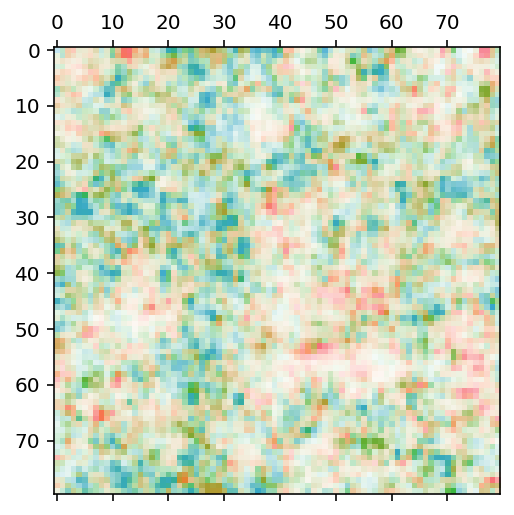

In [285]:
data = np.array(virial_mags)

# compute fft
data_ffts = np.fft.fft(data.T, axis=-1)

xs = np.fft.fftfreq(40)

idx = 2

grid = locality.particle_to_grid_square_cic(
    first_pos_htl[:, :2],
    np.abs(data_ffts[:, idx]).astype(np.float32),
    box[0],
    80
)

grid2 = locality.particle_to_grid_square_cic(
    first_pos_htl[:, :2],
    np.angle(data_ffts[:, idx]).astype(np.float32),
    box[0],
    80
)

# clear_fig_and_plot_grid(ax, grid, norm, float(max_shear), prep, colorbar)
# output_name = job.fn(f"videos/force-chain-movie/force-chain-movie-{frame:04d}.png")
# colorbar = False

# plt.savefig(output_name, dpi=150)

alpha = np.clip(grid.T/np.max(grid.T)*2, 0, 1)
plt.matshow(grid2.T + np.pi, alpha=alpha, norm=norm, cmap=sns.color_palette("husl", as_cmap=True))

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
ESL
Using pair function:  <function KA_LJ at 0x777eef7ebac0>


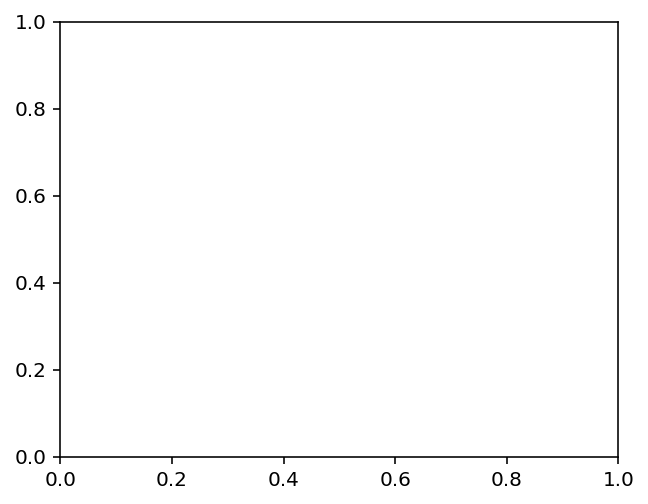

In [310]:
output = defaultdict(list)

fig, ax = plt.subplots(figsize=(5, 4))
colorbar = True

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "ESL":
        continue
    print(prep)
    txt_prep = prep.lower()
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    inter_computer = InteractionComputer(experiments[0], job.sp["pot"], frame=0)
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3 or float(max_shear) != 0.03:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue

        inter_computer.set_file(exper, frame=0)

        traj = gsd.hoomd.open(exper, "rb")

        # old_frames = glob.glob(job.fn(f"videos/force-chain-movie/force-chain-movie-*.png"))
        # for f in old_frames:
        #     os.remove(f)

        # output_file = f"videos/force-chain-movie-{txt_prep}_max-shear-{max_shear}_id-{job.id}.mp4"
        # if os.path.exists(output_file):
        #     continue
        # os.makedirs(job.fn("videos/force-chain-movie"), exist_ok=True)

        virial_mags2 = []

        first = True
        for frame, _, soft in dataset.rows()[:40]: # only take one cycle of data
            soft = np.array(soft)
            snap = traj[frame]
            box = snap.configuration.box
            square_box = np.array([box[0], box[1], 0, 0, 0, 0])
            freud_box = freud.box.Box.from_box(square_box)
            pos = freud_box.wrap(snap.particles.position)

            if first:
                first_pos = pos
                query = freud.locality.AABBQuery.from_system(snap)
                nlist = query.query(pos, {"num_neighbors": 10, "exclude_ii": False}).toNeighborList()

                first = False

            inter_computer.set_frame(frame)
            virials = inter_computer.get_virials()
            #virial_trace = virials[:, 0] + virials[:, 3]
            # virial_trace = virials[:, 1]
            xx = virials[:, 0]
            yy = virials[:, 3]
            xy = virials[:, 1]
            diff = xx - yy
            virial_mag = np.sqrt(xy**2 + diff**2)
            # average over neighbors
            virial_mag = mean_over_neighbors(virial_mag, nlist.segments, nlist.neighbor_counts, nlist.point_indices)
            virial_mags2.append(virial_mag)

            # norm = colors.Normalize(vmin=np.min(virial_trace),
            # vmax=np.max(virial_trace))
            
        

        # grid = locality.particle_to_grid_square_cic(
        #     first_pos[:, :2],
        #     virial_trace.astype(np.float32),
        #     box[0],
        #     160
        # )

        # clear_fig_and_plot_grid(ax, grid, norm, float(max_shear), prep, colorbar)
        # output_name = job.fn(f"videos/force-chain-movie/force-chain-movie-{frame:04d}.png")
        # colorbar = False

        # plt.savefig(output_name, dpi=150)
        # break

        break
    break

In [260]:
import seaborn as sns

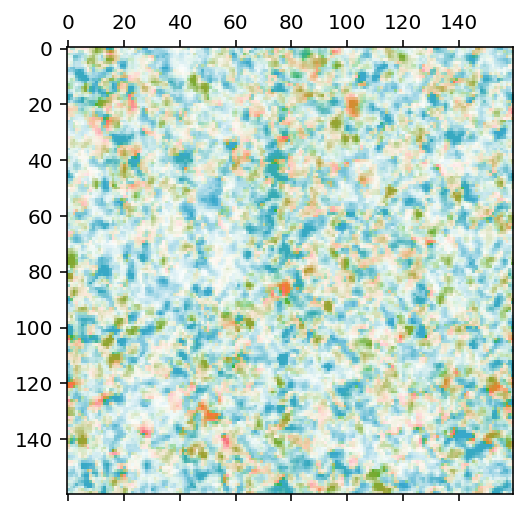

In [282]:
# def darken(x, ):
#    return x * 0.8

# # dark_hsv = cmap_map(darken, plt.get_cmap('hsv'))
# dark_hsv = cm.

data = np.array(virial_mags2)

# compute fft
data_ffts = np.fft.fft(data.T, axis=-1)

xs = np.fft.fftfreq(40)

idx = 2

grid = locality.particle_to_grid_square_cic(
    first_pos[:, :2],
    np.abs(data_ffts[:, idx]).astype(np.float32),
    box[0],
    160
)

grid2 = locality.particle_to_grid_square_cic(
    first_pos[:, :2],
    np.angle(data_ffts[:, idx]).astype(np.float32),
    box[0],
    160
)

# clear_fig_and_plot_grid(ax, grid, norm, float(max_shear), prep, colorbar)
# output_name = job.fn(f"videos/force-chain-movie/force-chain-movie-{frame:04d}.png")
# colorbar = False

# plt.savefig(output_name, dpi=150)

alpha = np.clip(grid.T/np.max(grid.T)*2, 0, 1)
plt.matshow(grid2.T + np.pi, alpha=alpha, norm=norm, cmap=sns.color_palette("husl", as_cmap=True))

In [255]:
dark_hsv.set_

AttributeError: 'LinearSegmentedColormap' object has no attribute 'gamma'

In [298]:
# norm = colors.LogNorm(vmin=1e-1, vmax=60)
norm = colors.Normalize(vmin=-np.pi, vmax=np.pi)

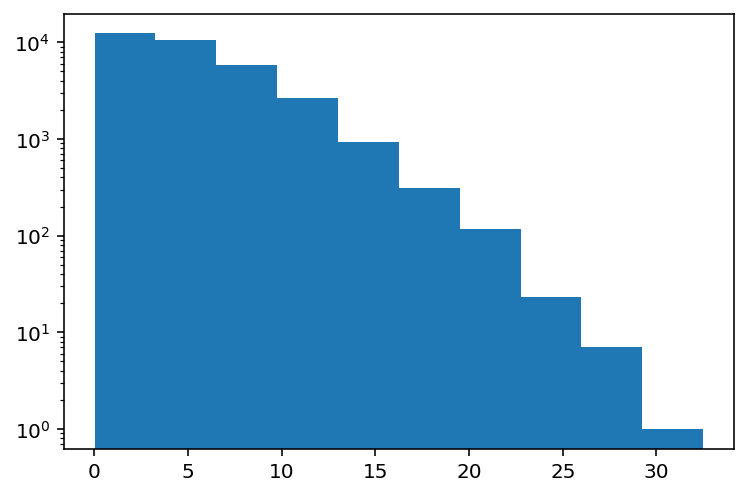

In [237]:
plt.hist((np.abs(data_ffts[:, 1])).flatten()),
plt.yscale("log")

In [344]:
shear = 0.03

634e14bc75836df75158fb15f379d8bb
HTL
Using pair function:  <function KA_LJ at 0x777eef7ebac0>


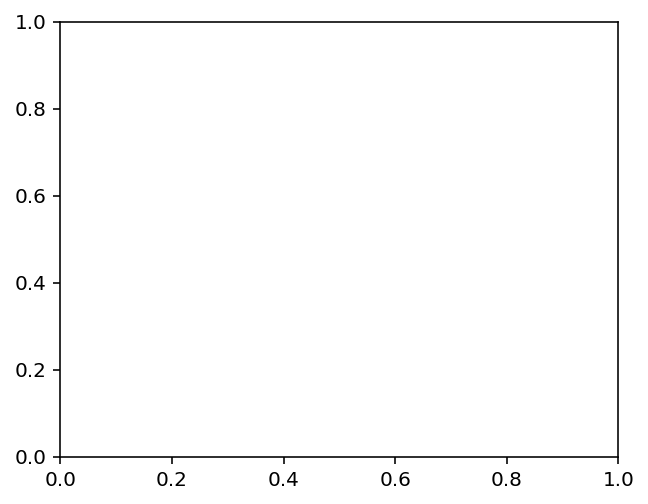

In [345]:
output = defaultdict(list)

fig, ax = plt.subplots(figsize=(5, 4))
colorbar = True

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "HTL":
        continue
    print(prep)
    txt_prep = prep.lower()
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    inter_computer = InteractionComputer(experiments[0], job.sp["pot"], frame=0)
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3 or float(max_shear) != shear:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue

        inter_computer.set_file(exper, frame=0)

        traj = gsd.hoomd.open(exper, "rb")

        # old_frames = glob.glob(job.fn(f"videos/force-chain-movie/force-chain-movie-*.png"))
        # for f in old_frames:
        #     os.remove(f)

        # output_file = f"videos/force-chain-movie-{txt_prep}_max-shear-{max_shear}_id-{job.id}.mp4"
        # if os.path.exists(output_file):
        #     continue
        # os.makedirs(job.fn("videos/force-chain-movie"), exist_ok=True)

        virial_mags = []

        first = True
        for frame, _, soft in dataset.rows()[:40]: # only take one cycle of data
            soft = np.array(soft)
            snap = traj[frame]
            box = snap.configuration.box
            square_box = np.array([box[0], box[1], 0, 0, 0, 0])
            freud_box = freud.box.Box.from_box(square_box)
            pos = freud_box.wrap(snap.particles.position)

            if first:
                first_pos_htl = pos
                query = freud.locality.AABBQuery.from_system(snap)
                nlist = query.query(pos, {"num_neighbors": 10, "exclude_ii": False}).toNeighborList()

                first = False

            inter_computer.set_frame(frame)
            virials = inter_computer.get_virials()
            #virial_trace = virials[:, 0] + virials[:, 3]
            # virial_trace = virials[:, 1]
            xx = virials[:, 0]
            yy = virials[:, 3]
            xy = virials[:, 1]
            diff = xx - yy
            virial_mag = np.sqrt(xy**2 + diff**2)
            # average of neighbors
            virial_mag = mean_over_neighbors(virial_mag, nlist.segments, nlist.neighbor_counts, nlist.point_indices)
            virial_mags.append(virial_mag)

            # norm = colors.Normalize(vmin=np.min(virial_trace),
            # vmax=np.max(virial_trace))
            
        

        # grid = locality.particle_to_grid_square_cic(
        #     first_pos[:, :2],
        #     virial_trace.astype(np.float32),
        #     box[0],
        #     160
        # )

        # clear_fig_and_plot_grid(ax, grid, norm, float(max_shear), prep, colorbar)
        # output_name = job.fn(f"videos/force-chain-movie/force-chain-movie-{frame:04d}.png")
        # colorbar = False

        # plt.savefig(output_name, dpi=150)
        # break

        break
    break

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
ESL
Using pair function:  <function KA_LJ at 0x777eef7ebac0>


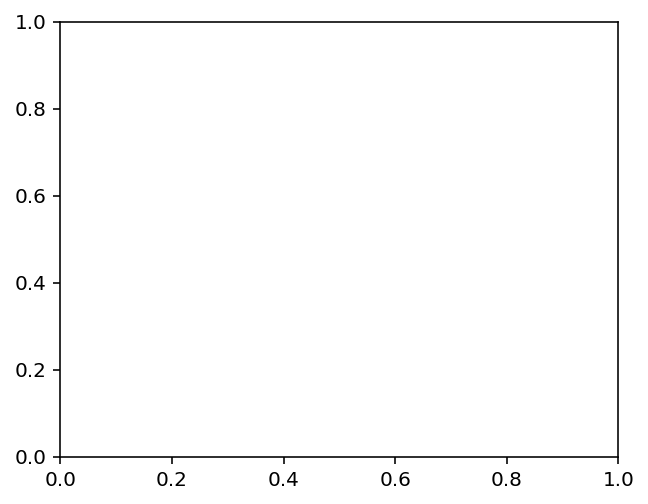

In [346]:
output = defaultdict(list)

fig, ax = plt.subplots(figsize=(5, 4))
colorbar = True

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "ESL":
        continue
    print(prep)
    txt_prep = prep.lower()
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    inter_computer = InteractionComputer(experiments[0], job.sp["pot"], frame=0)
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3 or float(max_shear) != shear:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue

        inter_computer.set_file(exper, frame=0)

        traj = gsd.hoomd.open(exper, "rb")

        # old_frames = glob.glob(job.fn(f"videos/force-chain-movie/force-chain-movie-*.png"))
        # for f in old_frames:
        #     os.remove(f)

        # output_file = f"videos/force-chain-movie-{txt_prep}_max-shear-{max_shear}_id-{job.id}.mp4"
        # if os.path.exists(output_file):
        #     continue
        # os.makedirs(job.fn("videos/force-chain-movie"), exist_ok=True)

        virial_mags2 = []

        first = True
        for frame, _, soft in dataset.rows()[:40]: # only take one cycle of data
            soft = np.array(soft)
            snap = traj[frame]
            box = snap.configuration.box
            square_box = np.array([box[0], box[1], 0, 0, 0, 0])
            freud_box = freud.box.Box.from_box(square_box)
            pos = freud_box.wrap(snap.particles.position)

            if first:
                first_pos = pos
                query = freud.locality.AABBQuery.from_system(snap)
                nlist = query.query(pos, {"num_neighbors": 10, "exclude_ii": False}).toNeighborList()

                first = False

            inter_computer.set_frame(frame)
            virials = inter_computer.get_virials()
            #virial_trace = virials[:, 0] + virials[:, 3]
            # virial_trace = virials[:, 1]
            xx = virials[:, 0]
            yy = virials[:, 3]
            xy = virials[:, 1]
            diff = xx - yy
            virial_mag = np.sqrt(xy**2 + diff**2)
            # average over neighbors
            virial_mag = mean_over_neighbors(virial_mag, nlist.segments, nlist.neighbor_counts, nlist.point_indices)
            virial_mags2.append(virial_mag)

            # norm = colors.Normalize(vmin=np.min(virial_trace),
            # vmax=np.max(virial_trace))
            
        

        # grid = locality.particle_to_grid_square_cic(
        #     first_pos[:, :2],
        #     virial_trace.astype(np.float32),
        #     box[0],
        #     160
        # )

        # clear_fig_and_plot_grid(ax, grid, norm, float(max_shear), prep, colorbar)
        # output_name = job.fn(f"videos/force-chain-movie/force-chain-movie-{frame:04d}.png")
        # colorbar = False

        # plt.savefig(output_name, dpi=150)
        # break

        break
    break

13.606947
10.313845


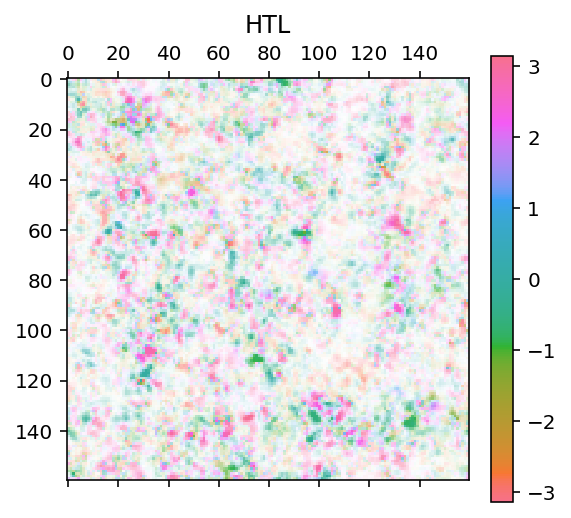

<Figure size 432x288 with 0 Axes>

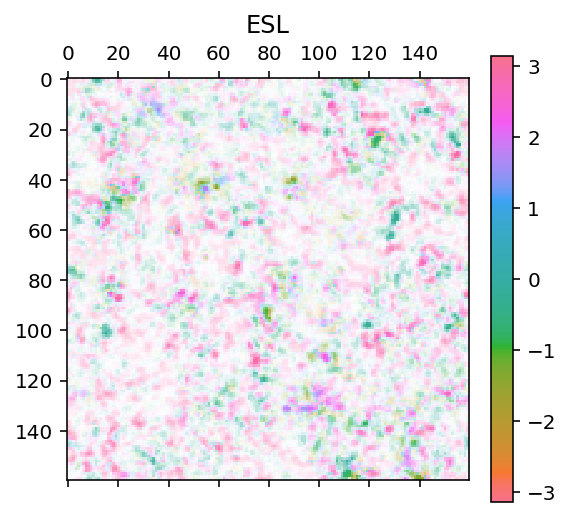

In [347]:
data = np.array(virial_mags)

# compute fft
data_ffts = np.fft.fft(data.T, axis=-1)

xs = np.fft.fftfreq(40)

idx = 2

bins = 160

grid = locality.particle_to_grid_square_cic(
    first_pos_htl[:, :2],
    np.abs(data_ffts[:, idx]).astype(np.float32),
    box[0],
    bins
)

grid2 = locality.particle_to_grid_square_cic(
    first_pos_htl[:, :2],
    np.angle(data_ffts[:, idx]).astype(np.float32),
    box[0],
    bins
)

# clear_fig_and_plot_grid(ax, grid, norm, float(max_shear), prep, colorbar)
# output_name = job.fn(f"videos/force-chain-movie/force-chain-movie-{frame:04d}.png")
# colorbar = False

# plt.savefig(output_name, dpi=150)

print(np.max(grid.T))

# alpha = np.clip(grid.T/np.max(grid.T)*2, 0, 1)
# maxa = 8
maxa = np.max(grid.T)*0.5
alpha = np.clip(grid.T/maxa, 0, 1)
plt.matshow(grid2.T, alpha=alpha, norm=norm, cmap=sns.color_palette("husl", as_cmap=True))
plt.title("HTL")
plt.colorbar(fraction = 0.05)

# def darken(x, ):
#    return x * 0.8

# # dark_hsv = cmap_map(darken, plt.get_cmap('hsv'))
# dark_hsv = cm.

plt.figure()

data = np.array(virial_mags2)

# compute fft
data_ffts = np.fft.fft(data.T, axis=-1)

xs = np.fft.fftfreq(40)

grid = locality.particle_to_grid_square_cic(
    first_pos[:, :2],
    np.abs(data_ffts[:, idx]).astype(np.float32),
    box[0],
    bins
)

grid2 = locality.particle_to_grid_square_cic(
    first_pos[:, :2],
    np.angle(data_ffts[:, idx]).astype(np.float32),
    box[0],
    bins
)

# clear_fig_and_plot_grid(ax, grid, norm, float(max_shear), prep, colorbar)
# output_name = job.fn(f"videos/force-chain-movie/force-chain-movie-{frame:04d}.png")
# colorbar = False

# plt.savefig(output_name, dpi=150)

print(np.max(grid.T))

# alpha = np.clip(grid.T/np.max(grid.T)*2, 0, 1)
alpha = np.clip(grid.T/maxa, 0, 1)
plt.matshow(grid2.T, alpha=alpha, norm=norm, cmap=sns.color_palette("husl", as_cmap=True))
plt.title("ESL")
plt.colorbar(fraction = 0.05)

29.330973
20.922304


(0.0, 5000.0)

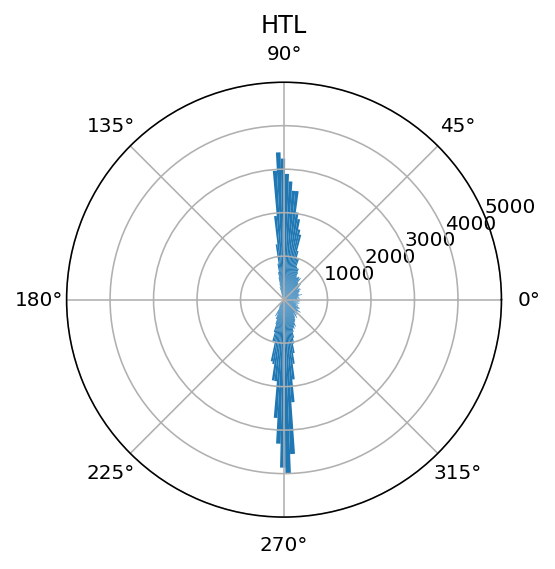

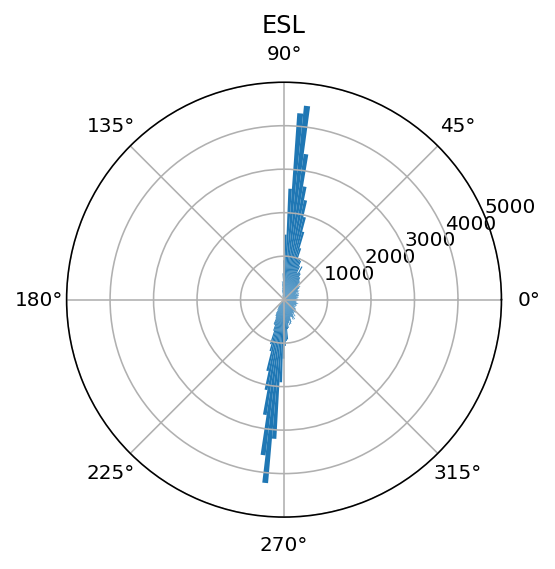

In [348]:
data = np.array(virial_mags)

# compute fft
data_ffts = np.fft.fft(data.T, axis=-1)

xs = np.fft.fftfreq(40)

idx = 1

bins = 160

grid = locality.particle_to_grid_square_cic(
    first_pos_htl[:, :2],
    np.abs(data_ffts[:, idx]).astype(np.float32),
    box[0],
    bins
)

grid2 = locality.particle_to_grid_square_cic(
    first_pos_htl[:, :2],
    np.angle(data_ffts[:, idx]).astype(np.float32),
    box[0],
    bins
)

# clear_fig_and_plot_grid(ax, grid, norm, float(max_shear), prep, colorbar)
# output_name = job.fn(f"videos/force-chain-movie/force-chain-movie-{frame:04d}.png")
# colorbar = False

# plt.savefig(output_name, dpi=150)

print(np.max(grid.T))

# alpha = np.clip(grid.T/np.max(grid.T)*2, 0, 1)
# maxa = 8
maxa = np.max(grid.T)*0.5
alpha = np.clip(grid.T/maxa, 0, 1)
# plt.matshow(grid2.T, alpha=alpha, norm=norm, cmap=sns.color_palette("husl",
# as_cmap=True))
ax = plt.subplot(111, polar=True)
H, edges = np.histogram(grid2.flatten(), weights=grid.flatten(), bins=np.linspace(-np.pi, np.pi, 200))
plt.bar(edges[:-1], H, width=np.diff(edges), align="edge")
plt.title("HTL")
# plt.colorbar(fraction = 0.05)

# def darken(x, ):
#    return x * 0.8

# # dark_hsv = cmap_map(darken, plt.get_cmap('hsv'))
# dark_hsv = cm.
plt.ylim(0, 5000)

plt.figure()
ax = plt.subplot(111, polar=True)

data = np.array(virial_mags2)

# compute fft
data_ffts = np.fft.fft(data.T, axis=-1)

xs = np.fft.fftfreq(40)

grid = locality.particle_to_grid_square_cic(
    first_pos[:, :2],
    np.abs(data_ffts[:, idx]).astype(np.float32),
    box[0],
    bins
)

grid2 = locality.particle_to_grid_square_cic(
    first_pos[:, :2],
    np.angle(data_ffts[:, idx]).astype(np.float32),
    box[0],
    bins
)

# clear_fig_and_plot_grid(ax, grid, norm, float(max_shear), prep, colorbar)
# output_name = job.fn(f"videos/force-chain-movie/force-chain-movie-{frame:04d}.png")
# colorbar = False

# plt.savefig(output_name, dpi=150)

print(np.max(grid.T))

# alpha = np.clip(grid.T/np.max(grid.T)*2, 0, 1)
alpha = np.clip(grid.T/maxa, 0, 1)
# plt.matshow(grid2.T, alpha=alpha, norm=norm, cmap=sns.color_palette("husl",
# as_cmap=True))
H, edges = np.histogram(grid2.flatten(), weights=grid.flatten(), bins=np.linspace(-np.pi, np.pi, 200))
plt.bar(edges[:-1], H, width=np.diff(edges), align="edge")
# plt.title("HTL")
plt.title("ESL")
plt.ylim(0, 5000)
# plt.colorbar(fraction = 0.05)

13.606947
10.313845


(0.0, 2000.0)

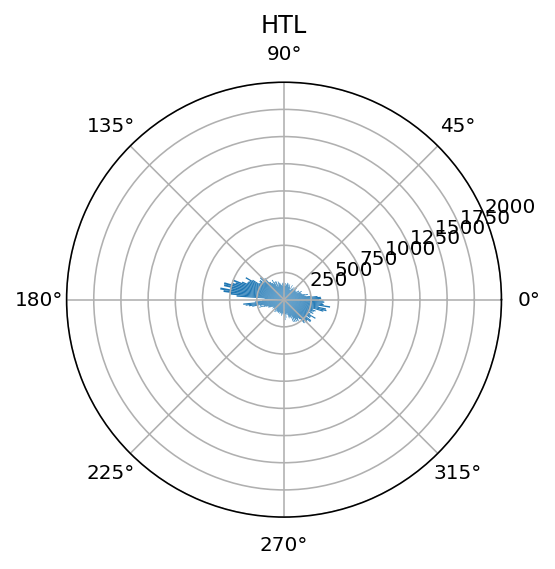

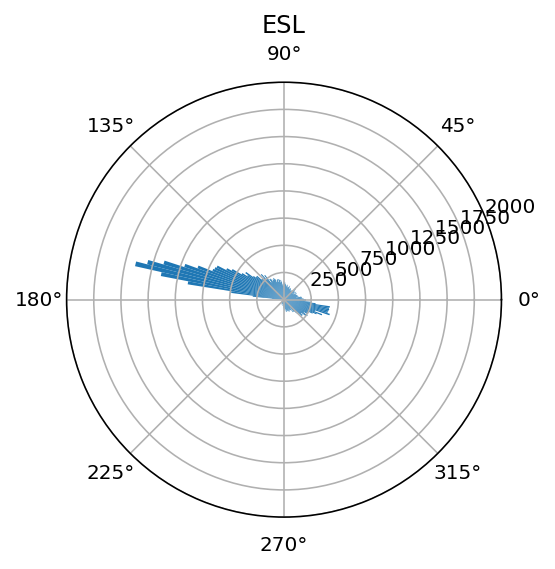

In [349]:
data = np.array(virial_mags)

# compute fft
data_ffts = np.fft.fft(data.T, axis=-1)

xs = np.fft.fftfreq(40)

idx = 2

bins = 160

grid = locality.particle_to_grid_square_cic(
    first_pos_htl[:, :2],
    np.abs(data_ffts[:, idx]).astype(np.float32),
    box[0],
    bins
)

grid2 = locality.particle_to_grid_square_cic(
    first_pos_htl[:, :2],
    np.angle(data_ffts[:, idx]).astype(np.float32),
    box[0],
    bins
)

# clear_fig_and_plot_grid(ax, grid, norm, float(max_shear), prep, colorbar)
# output_name = job.fn(f"videos/force-chain-movie/force-chain-movie-{frame:04d}.png")
# colorbar = False

# plt.savefig(output_name, dpi=150)

print(np.max(grid.T))

# alpha = np.clip(grid.T/np.max(grid.T)*2, 0, 1)
# maxa = 8
maxa = np.max(grid.T)*0.5
alpha = np.clip(grid.T/maxa, 0, 1)
# plt.matshow(grid2.T, alpha=alpha, norm=norm, cmap=sns.color_palette("husl",
# as_cmap=True))
ax = plt.subplot(111, polar=True)
H, edges = np.histogram(grid2.flatten(), weights=grid.flatten(), bins=np.linspace(-np.pi, np.pi, 200))
plt.bar(edges[:-1], H, width=np.diff(edges), align="edge")
plt.title("HTL")
# plt.colorbar(fraction = 0.05)

# def darken(x, ):
#    return x * 0.8

# # dark_hsv = cmap_map(darken, plt.get_cmap('hsv'))
# dark_hsv = cm.
plt.ylim(0, 2000)

plt.figure()
ax = plt.subplot(111, polar=True)

data = np.array(virial_mags2)

# compute fft
data_ffts = np.fft.fft(data.T, axis=-1)

xs = np.fft.fftfreq(40)

grid = locality.particle_to_grid_square_cic(
    first_pos[:, :2],
    np.abs(data_ffts[:, idx]).astype(np.float32),
    box[0],
    bins
)

grid2 = locality.particle_to_grid_square_cic(
    first_pos[:, :2],
    np.angle(data_ffts[:, idx]).astype(np.float32),
    box[0],
    bins
)

# clear_fig_and_plot_grid(ax, grid, norm, float(max_shear), prep, colorbar)
# output_name = job.fn(f"videos/force-chain-movie/force-chain-movie-{frame:04d}.png")
# colorbar = False

# plt.savefig(output_name, dpi=150)

print(np.max(grid.T))

# alpha = np.clip(grid.T/np.max(grid.T)*2, 0, 1)
alpha = np.clip(grid.T/maxa, 0, 1)
# plt.matshow(grid2.T, alpha=alpha, norm=norm, cmap=sns.color_palette("husl",
# as_cmap=True))
H, edges = np.histogram(grid2.flatten(), weights=grid.flatten(), bins=np.linspace(-np.pi, np.pi, 200))
plt.bar(edges[:-1], H, width=np.diff(edges), align="edge")
# plt.title("HTL")
plt.title("ESL")
plt.ylim(0, 2000)
# plt.colorbar(fraction = 0.05)

6.2657804
3.9164977


(0.0, 300.0)

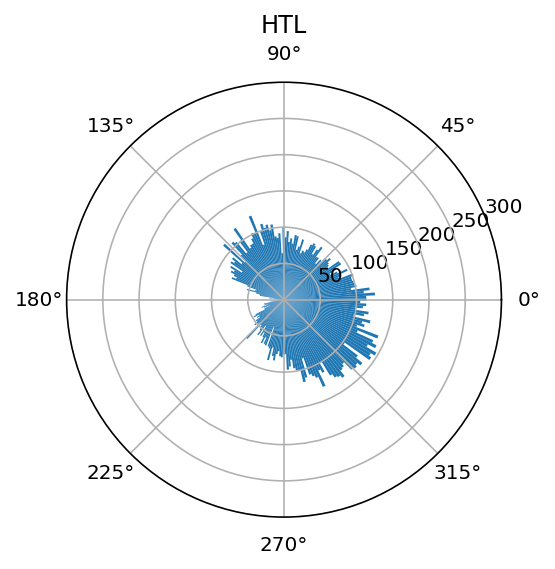

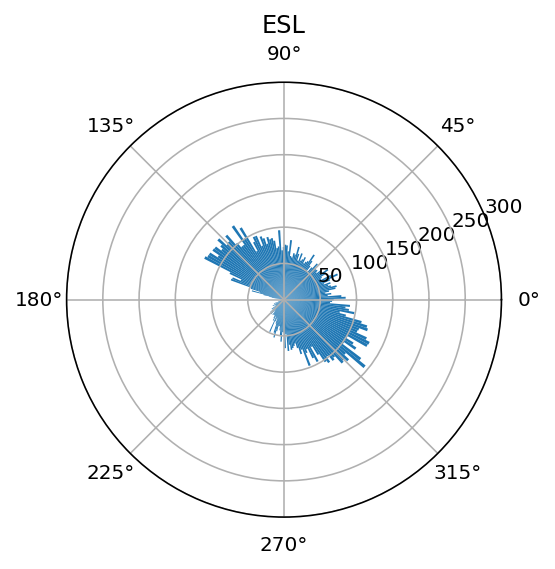

In [350]:
data = np.array(virial_mags)

# compute fft
data_ffts = np.fft.fft(data.T, axis=-1)

xs = np.fft.fftfreq(40)

idx = 4

bins = 160

grid = locality.particle_to_grid_square_cic(
    first_pos_htl[:, :2],
    np.abs(data_ffts[:, idx]).astype(np.float32),
    box[0],
    bins
)

grid2 = locality.particle_to_grid_square_cic(
    first_pos_htl[:, :2],
    np.angle(data_ffts[:, idx]).astype(np.float32),
    box[0],
    bins
)

# clear_fig_and_plot_grid(ax, grid, norm, float(max_shear), prep, colorbar)
# output_name = job.fn(f"videos/force-chain-movie/force-chain-movie-{frame:04d}.png")
# colorbar = False

# plt.savefig(output_name, dpi=150)

print(np.max(grid.T))

# alpha = np.clip(grid.T/np.max(grid.T)*2, 0, 1)
# maxa = 8
maxa = np.max(grid.T)*0.5
alpha = np.clip(grid.T/maxa, 0, 1)
# plt.matshow(grid2.T, alpha=alpha, norm=norm, cmap=sns.color_palette("husl",
# as_cmap=True))
ax = plt.subplot(111, polar=True)
H, edges = np.histogram(grid2.flatten(), weights=grid.flatten(), bins=np.linspace(-np.pi, np.pi, 200))
plt.bar(edges[:-1], H, width=np.diff(edges), align="edge")
plt.title("HTL")
plt.ylim(0, 300)
# plt.colorbar(fraction = 0.05)

# def darken(x, ):
#    return x * 0.8

# # dark_hsv = cmap_map(darken, plt.get_cmap('hsv'))
# dark_hsv = cm.

plt.figure()
ax = plt.subplot(111, polar=True)

data = np.array(virial_mags2)

# compute fft
data_ffts = np.fft.fft(data.T, axis=-1)

xs = np.fft.fftfreq(40)

grid = locality.particle_to_grid_square_cic(
    first_pos[:, :2],
    np.abs(data_ffts[:, idx]).astype(np.float32),
    box[0],
    bins
)

grid2 = locality.particle_to_grid_square_cic(
    first_pos[:, :2],
    np.angle(data_ffts[:, idx]).astype(np.float32),
    box[0],
    bins
)

# clear_fig_and_plot_grid(ax, grid, norm, float(max_shear), prep, colorbar)
# output_name = job.fn(f"videos/force-chain-movie/force-chain-movie-{frame:04d}.png")
# colorbar = False

# plt.savefig(output_name, dpi=150)

print(np.max(grid.T))

# alpha = np.clip(grid.T/np.max(grid.T)*2, 0, 1)
alpha = np.clip(grid.T/maxa, 0, 1)
# plt.matshow(grid2.T, alpha=alpha, norm=norm, cmap=sns.color_palette("husl",
# as_cmap=True))
H, edges = np.histogram(grid2.flatten(), weights=grid.flatten(), bins=np.linspace(-np.pi, np.pi, 200))
plt.bar(edges[:-1], H, width=np.diff(edges), align="edge")
# plt.title("HTL")
plt.title("ESL")
plt.ylim(0, 300)
# plt.colorbar(fraction = 0.05)

6.2657804
3.9164977


(0.0, 300.0)

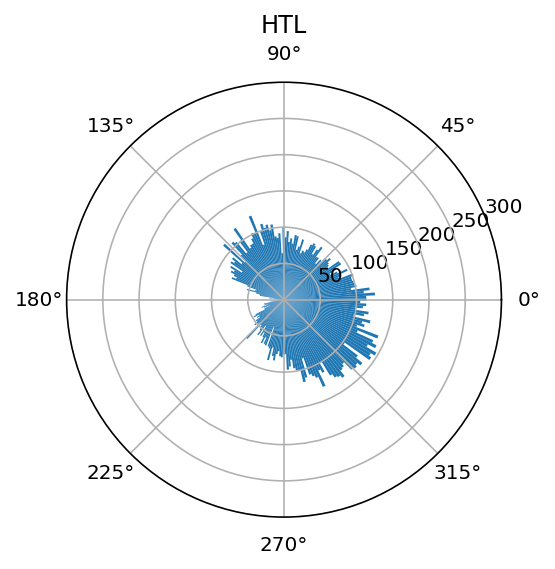

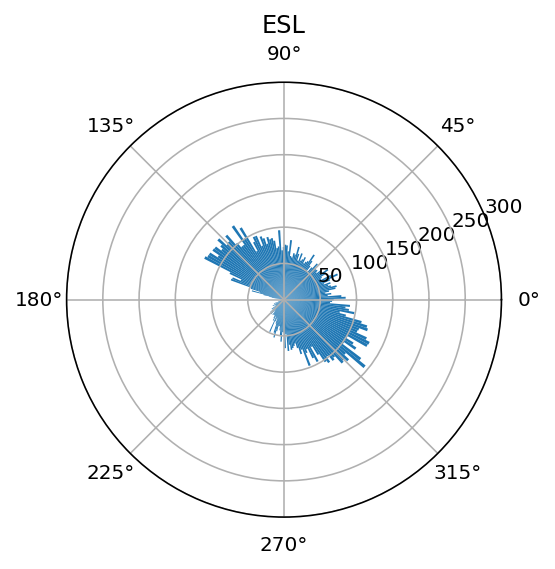

In [351]:
data = np.array(virial_mags)

# compute fft
data_ffts = np.fft.fft(data.T, axis=-1)

xs = np.fft.fftfreq(40)

idx0 = 2
idx = 4

bins = 160

grid = locality.particle_to_grid_square_cic(
    first_pos_htl[:, :2],
    np.abs(data_ffts[:, idx]).astype(np.float32),
    box[0],
    bins
)

grid2 = locality.particle_to_grid_square_cic(
    first_pos_htl[:, :2],
    np.angle(data_ffts[:, idx]).astype(np.float32),
    box[0],
    bins
)

# clear_fig_and_plot_grid(ax, grid, norm, float(max_shear), prep, colorbar)
# output_name = job.fn(f"videos/force-chain-movie/force-chain-movie-{frame:04d}.png")
# colorbar = False

# plt.savefig(output_name, dpi=150)

print(np.max(grid.T))

# alpha = np.clip(grid.T/np.max(grid.T)*2, 0, 1)
# maxa = 8
maxa = np.max(grid.T)*0.5
alpha = np.clip(grid.T/maxa, 0, 1)
# plt.matshow(grid2.T, alpha=alpha, norm=norm, cmap=sns.color_palette("husl",
# as_cmap=True))
ax = plt.subplot(111, polar=True)
H, edges = np.histogram(grid2.flatten(), weights=grid.flatten(), bins=np.linspace(-np.pi, np.pi, 200))
plt.bar(edges[:-1], H, width=np.diff(edges), align="edge")
plt.title("HTL")
plt.ylim(0, 300)
# plt.colorbar(fraction = 0.05)

# def darken(x, ):
#    return x * 0.8

# # dark_hsv = cmap_map(darken, plt.get_cmap('hsv'))
# dark_hsv = cm.

plt.figure()
ax = plt.subplot(111, polar=True)

data = np.array(virial_mags2)

# compute fft
data_ffts = np.fft.fft(data.T, axis=-1)

xs = np.fft.fftfreq(40)

grid = locality.particle_to_grid_square_cic(
    first_pos[:, :2],
    np.abs(data_ffts[:, idx]).astype(np.float32),
    box[0],
    bins
)

grid2 = locality.particle_to_grid_square_cic(
    first_pos[:, :2],
    np.angle(data_ffts[:, idx]).astype(np.float32),
    box[0],
    bins
)

# clear_fig_and_plot_grid(ax, grid, norm, float(max_shear), prep, colorbar)
# output_name = job.fn(f"videos/force-chain-movie/force-chain-movie-{frame:04d}.png")
# colorbar = False

# plt.savefig(output_name, dpi=150)

print(np.max(grid.T))

# alpha = np.clip(grid.T/np.max(grid.T)*2, 0, 1)
alpha = np.clip(grid.T/maxa, 0, 1)
# plt.matshow(grid2.T, alpha=alpha, norm=norm, cmap=sns.color_palette("husl",
# as_cmap=True))
H, edges = np.histogram(grid2.flatten(), weights=grid.flatten(), bins=np.linspace(-np.pi, np.pi, 200))
plt.bar(edges[:-1], H, width=np.diff(edges), align="edge")
# plt.title("HTL")
plt.title("ESL")
plt.ylim(0, 300)
# plt.colorbar(fraction = 0.05)